In [12]:
import dgl
import torch
import torch.nn as nn
import torch.nn.functional as F
import itertools
import pandas as pd

In [44]:
def load_zachery():
    nodes_data = pd.read_csv('./data/nodes.csv')
    edges_data = pd.read_csv('./data/edges.csv')
    src = edges_data['Src'].to_numpy()
    dst = edges_data['Dst'].to_numpy()
    g = dgl.graph((src, dst))
    club = nodes_data['Club'].to_list()
    # Convert to categorical integer values with 0 for 'Mr. Hi', 1 for 'Officer'.
    club = torch.tensor([c == 'Officer' for c in club]).long()
    # We can also convert it to one-hot encoding.
    club_onehot = F.one_hot(club)
    g.ndata.update({'club' : club, 'club_onehot' : club_onehot})
    return g
# 0. load graph
g = load_zachery()
print(g)

Graph(num_nodes=34, num_edges=156,
      ndata_schemes={'club': Scheme(shape=(), dtype=torch.int64), 'club_onehot': Scheme(shape=(2,), dtype=torch.int64)}
      edata_schemes={})


In [14]:
node_embed = nn.Embedding(g.number_of_nodes(),5)
inputs = node_embed.weight

In [18]:
nn.init.xavier_uniform_(inputs)

Parameter containing:
tensor([[ 0.2695, -0.1147,  0.3830, -0.1840,  0.1857],
        [-0.1779, -0.0529,  0.2167,  0.2100,  0.2668],
        [ 0.0362,  0.0108,  0.3487,  0.2896, -0.1454],
        [-0.0343,  0.1850,  0.3703, -0.2571, -0.1894],
        [-0.3199,  0.1653,  0.0423, -0.3637, -0.1420],
        [ 0.2274,  0.1714,  0.0249,  0.3808, -0.3358],
        [ 0.0757, -0.0599,  0.2001,  0.0278,  0.0414],
        [-0.1826,  0.1855, -0.3675,  0.2929,  0.3721],
        [ 0.0435, -0.3601, -0.0926,  0.2114, -0.2310],
        [ 0.1925, -0.1929, -0.2544, -0.3228,  0.2049],
        [ 0.3207, -0.1090, -0.2634, -0.1300,  0.0439],
        [-0.1461,  0.3726,  0.3891, -0.3036, -0.1764],
        [-0.0375, -0.2197,  0.2973, -0.0192, -0.0200],
        [-0.3147, -0.3757,  0.1768,  0.2160, -0.0796],
        [-0.3645, -0.0225, -0.2532,  0.0973, -0.0727],
        [-0.1200,  0.0855, -0.0072,  0.0563,  0.3274],
        [-0.0890, -0.0636,  0.1048,  0.2251,  0.2774],
        [ 0.0745,  0.2568,  0.1651, -0.1111

In [19]:
labels = g.ndata['club']
labeled_nodes = [0,33]
print('Labels', labels[labeled_nodes])

Labels tensor([0, 1])


In [20]:
print(g)

Graph(num_nodes=34, num_edges=156,
      ndata_schemes={'club': Scheme(shape=(), dtype=torch.int64), 'club_onehot': Scheme(shape=(2,), dtype=torch.int64)}
      edata_schemes={})


In [36]:
from dgl.nn import SAGEConv
class GraphSAGE(nn.Module):
    def __init__(self, in_feats, h_feats, num_classes):
        super(GraphSAGE, self).__init__()
        self.conv1 = SAGEConv(in_feats, h_feats, 'mean')
        self.conv2 = SAGEConv(h_feats, num_classes, 'mean')

    def forward(self, g, in_feat):
        h = self.conv1(g, in_feat)
        h = F.relu(h)
        h = self.conv2(g, h)
        return h
net = GraphSAGE(5, 16, 2)


In [37]:
optimizer = torch.optim.Adam(itertools.chain(net.parameters(), node_embed.parameters()), lr=0.01)

In [38]:
all_logits = []
for e in range(100):
    # forward
    logits = net(g, inputs)

    # 손실 계산
    logp = F.log_softmax(logits, 1)
    loss = F.nll_loss(logp[labeled_nodes], labels[labeled_nodes])

    # backward
    optimizer.zero_grad()
    loss.backward()
    optimizer.step()
    all_logits.append(logits.detach())

    if e % 5 == 0:
        print('In epoch {}, loss: {}'.format(e, loss))


In epoch 0, loss: 0.3509654402732849
In epoch 5, loss: 0.037484582513570786
In epoch 10, loss: 0.007683290168642998
In epoch 15, loss: 0.002342858351767063
In epoch 20, loss: 0.0009856417309492826
In epoch 25, loss: 0.0005519269034266472
In epoch 30, loss: 0.0003695788327604532
In epoch 35, loss: 0.0002801487280521542
In epoch 40, loss: 0.00023081238032318652
In epoch 45, loss: 0.00020095898071303964
In epoch 50, loss: 0.00018141369218938053
In epoch 55, loss: 0.00016770788352005184
In epoch 60, loss: 0.00015733901818748564
In epoch 65, loss: 0.00014911533799022436
In epoch 70, loss: 0.0001422026107320562
In epoch 75, loss: 0.0001361241447739303
In epoch 80, loss: 0.0001306415506405756
In epoch 85, loss: 0.0001255164825124666
In epoch 90, loss: 0.00012074894038960338
In epoch 95, loss: 0.00011627934873104095


In [39]:
# ----------- 5. check results ------------------------ #
pred = torch.argmax(logits, axis=1)
print('Accuracy', (pred == labels).sum().item() / len(pred))

Accuracy 0.6470588235294118


In [40]:
# 약간의 셋팅을 합니다. 이 셀은 무시하셔도 됩니다.
import matplotlib.pyplot as plt

# 외부 모듈의 자동 reloading
%load_ext autoreload
%autoreload 2

%matplotlib inline
plt.rcParams['figure.figsize'] = (4.0, 3.0) # 플롯의 기본 사이즈 설정
plt.rcParams['image.interpolation'] = 'nearest'
plt.rcParams['image.cmap'] = 'gray'
plt.rcParams['animation.html'] = 'html5'

In [41]:
len(all_logits)

100

MovieWriter stderr:
[libopenh264 @ 0x7f973d80ac00] Incorrect library version loaded
Error initializing output stream 0:0 -- Error while opening encoder for output stream #0:0 - maybe incorrect parameters such as bit_rate, rate, width or height



CalledProcessError: Command '['ffmpeg', '-f', 'rawvideo', '-vcodec', 'rawvideo', '-s', '600x450', '-pix_fmt', 'rgba', '-r', '5.0', '-loglevel', 'error', '-i', 'pipe:', '-vcodec', 'h264', '-pix_fmt', 'yuv420p', '-y', '/var/folders/0m/hjk2tg755515lw68ngg0ch940000gn/T/tmpi6zbgywo/temp.m4v']' returned non-zero exit status 1.

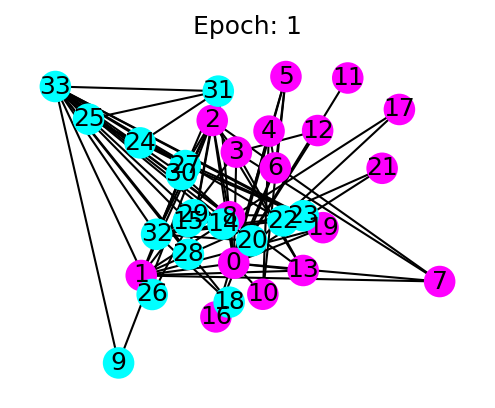

In [46]:
# 노드 분류를 로짓 출력을 사용해 시각화합니다. ffmpeg가 필요합니다.
import networkx as nx
import numpy as np
import matplotlib.animation as animation
from IPython.display import HTML

fig = plt.figure(dpi=150)
fig.clf()
ax = fig.subplots()
nx_G = g.to_networkx()
def draw(i):
    cls1color = '#00FFFF'
    cls2color = '#FF00FF'
    pos = {}
    colors = []
    for v in range(34):
        pred = all_logits[i].numpy()
        pos[v] = pred[v]
        cls = labels[v]
        colors.append(cls1color if cls else cls2color)
    ax.cla()
    ax.axis('off')
    ax.set_title('Epoch: %d' % i)
    nx.draw(nx_G.to_undirected(), pos, node_color=colors, with_labels=True, node_size=200)

ani = animation.FuncAnimation(fig, draw, frames=len(all_logits), interval=200)
HTML(ani.to_html5_video())

In [54]:
m1 = torch.FloatTensor([[1,2],[3,4]])
m2 = torch.FloatTensor([[1],[2]])
print(m1.matmul(m2))


tensor([[ 5.],
        [11.]])


$$ \alpha = \beta $$

In [56]:
t = np.array([[[0, 1, 2],
               [3, 4, 5]],
              [[6, 7, 8],
               [9, 10, 11]]])
ft = torch.FloatTensor(t)

In [57]:
ft.view([-1,6])

tensor([[ 0.,  1.,  2.,  3.,  4.,  5.],
        [ 6.,  7.,  8.,  9., 10., 11.]])